# 🐕 End-to-End Multi-Class Dog Breed Classification.

This notebook builds an multi-class image classifier using TenserFlow 2.0 and TensorFlow Hub.

## 1. Problem

Indentifying the breed of a dog given an image of a dog.

"When I am sitting at a cafe and I see a cute dog, would love to know the breed of it."


## 2. Data

https://www.kaggle.com/c/dog-breed-identification/data

 The data we are using is from kaggle's dog breed indentification competitions.


## 3. Evaluation

The evalutions is a file with predictions probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview

## 4. Features

- We are dealing with images (unstructured data) so it's probably it is best to use deep learning/ transfer learning.

- We have training set and a test set of images of dogs. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs.

- There are around 10,000+ images in the training set(these images have labels).
- There are around 10,000+ images in the test set(these images have no labels).

- File descriptions
  - train.zip - the training set, you are provided the breed for these dogs
  - test.zip - the test set, you must predict the probability of each breed for each image
  - sample_submission.csv - a sample submission file in the correct format
  - labels.csv - the breeds for the images in the train set

## Getting Workspace Ready

- Import TensorFlow 2.x
- Import TensorFlow Hub
- Make sure we are using GPU

In [1]:
#Import neccesary tools
import tensorflow_hub as hub
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TensorFlow version: 2.18.0
Hub version: 0.16.1
GPU is NOT AVAILABLE


## Getting our data ready (turning it into Tensors)

With all machine learning models, our data should be in numerical format. So, that's what we'll be doing first. Turning our images into Tensors (numerical representation more like numpy arrays with multiple dimensions)


In [2]:
# checkout labels of our data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126


In [3]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
# how many images are there of each breed
labels_csv["breed"].value_counts()

,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
...,...
golden_retriever,67
komondor,67
brabancon_griffon,67


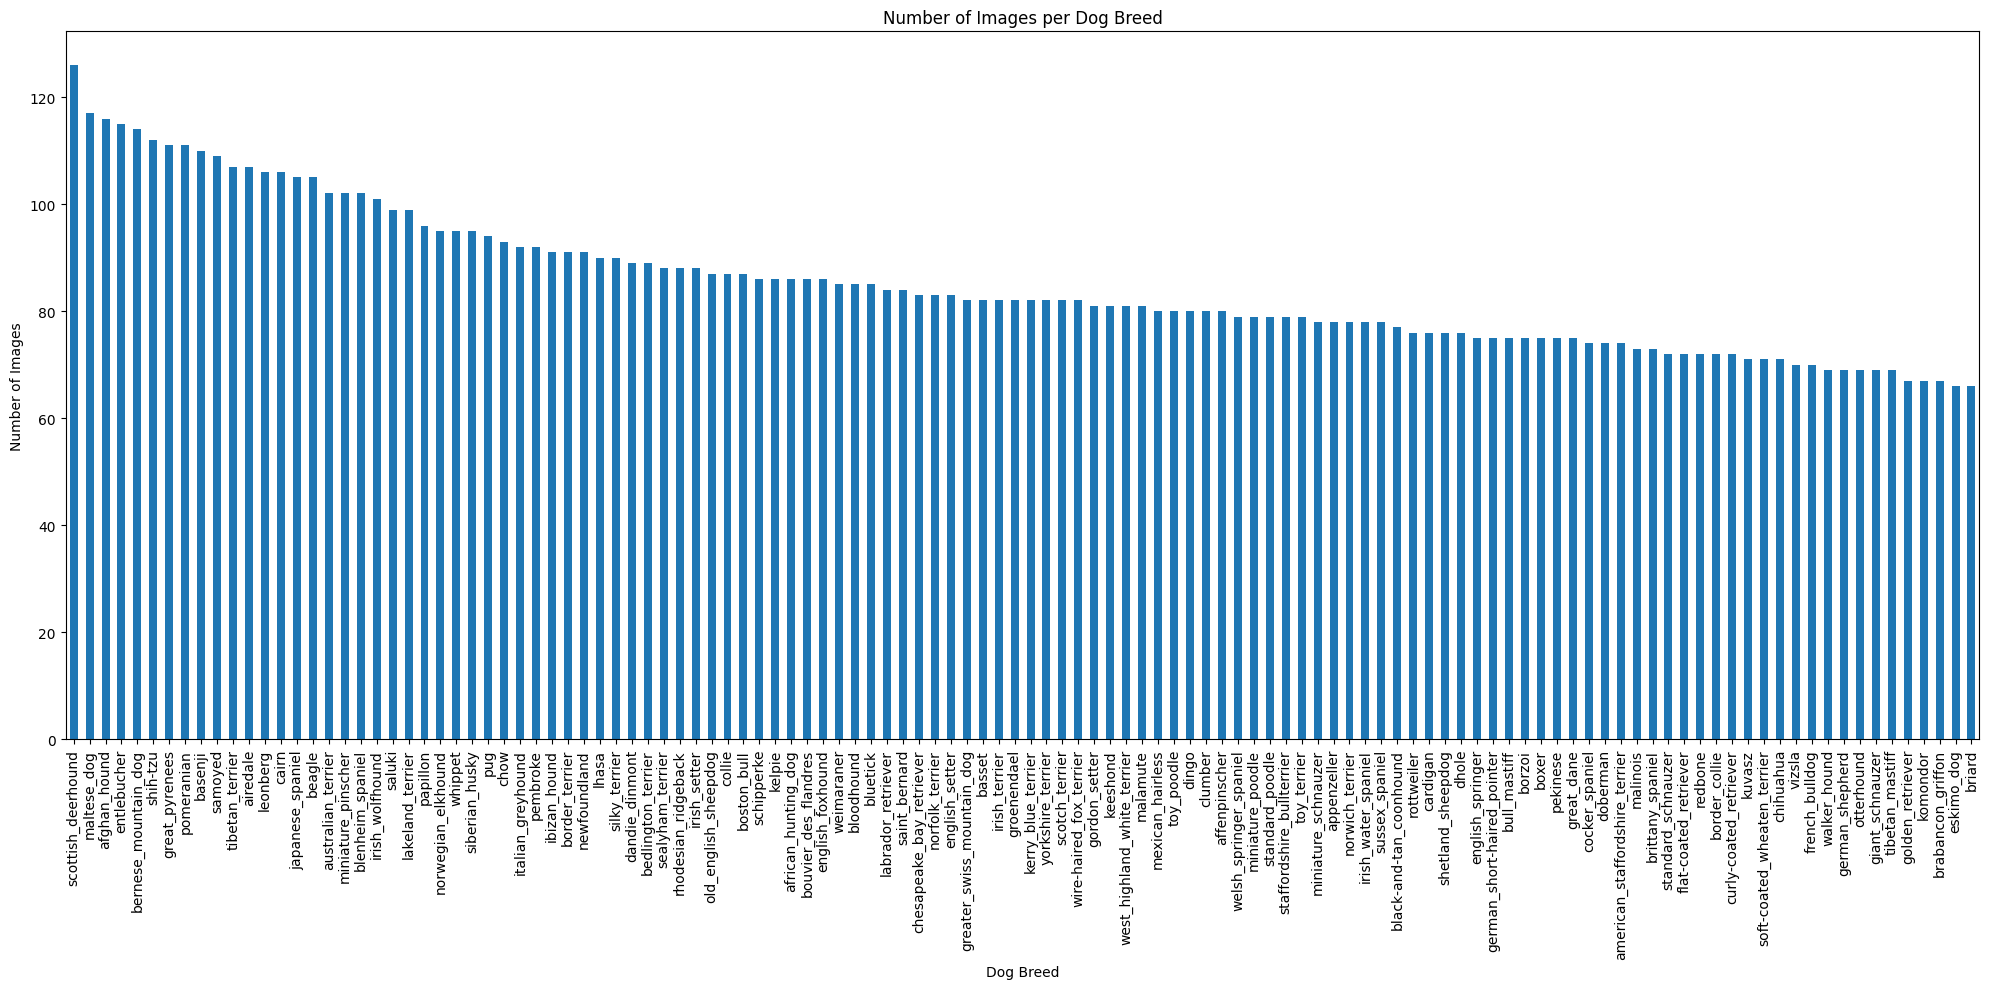

In [5]:
import matplotlib.pyplot as plt

breed_counts = labels_csv["breed"].value_counts()

# Create the bar plot
plt.figure(figsize=(20, 10))  # Adjust figure size as needed
breed_counts.plot(kind='bar')
plt.title('Number of Images per Dog Breed')
plt.xlabel('Dog Breed')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


In [6]:
labels_csv["breed"].value_counts().median()

82.0

In [7]:
# Viewing the image
from IPython.display import Image
Image("/content/drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg")

KeyboardInterrupt: 

### Getting images and there labels

Lets get list of all of our image file pathnames

In [ ]:
labels_csv.head()

In [ ]:
# Create pathnames from image ID's
filenames = ["/content/drive/MyDrive/Dog Vision/train/"+fname for fname in labels_csv["id"]+".jpg"]
filenames[:10]

In [ ]:
Image(filenames[11])

In [ ]:
# check whether number of filename matches number of actual image files
import os
if len(os.listdir("/content/drive/MyDrive/Dog Vision/train")) == len(filenames):
  print("Filenames match actual amount of files")
else:
  print("Filenames do not match actual amount of files")

Since we'have now got our training image filepaths in a list. lets prepare our labels.

In [ ]:
import numpy as np
labels = labels_csv["breed"]#.to_numpy() does same thing as below
labels = np.array(labels)
labels

In [ ]:
len(labels)

In [ ]:
# Check if number of labels matches the number of filenames to see if there are missing data
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else:
  print("Number of labels does not match number of filenames")

In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

In [ ]:
# turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

In [ ]:
# Turn every single labels into boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

In [ ]:
len(boolean_labels)

### Creating our own validation set

Our data set does not have a validation set so, we will need to create one.

In [ ]:
# Set up X and y variables
X = filenames # this is our training and validation input the images
y = boolean_labels # this is our target labels, they are boolean arrays
# each array has a true value corresponding to the label.

We are going to start off experinmenting with ~1000 images and then increase as needed.

In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 # @param {"type":"slider","min":1000,"max":10222,"step":100}

In [ ]:
# Lets split our data into train and validation sets
from sklearn.model_selection import train_test_split
# split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES],
                                                  test_size=0.2, random_state=42)


In [ ]:
len(X_train), len(y_train), len(X_val), len(y_val)

## Preprocessing Images (turning images into tensors)

To preprocess our images into Tensors we are going to write a fucntion which does a few things:

1. Take image filepath as input.
2. Use TensorFlow to read the file and save it to a variable, `image`.
3. Turn our `image` (a jpg) into Tensors.
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224,224).
The reason for specific size depends on which model you choose to train. Certain models have size requirements.
6. Return the modified `image`



In [ ]:
# convert image to NumPy array
# .shape gives this info (height, width, color chanels)
# color chanels 3 means it is RGB
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

In [ ]:
image.max(), image.min()

In [ ]:
image[:2]

In [ ]:
# turn image into tensor
tf.constant(image)[:2]

#### Now we have seen what image looks like as tensor, so lets build a function to preprocess them.

In [ ]:
# Define image size which is (224, 224)

IMG_SIZE = 224

# Create a funtion for preproccessing images
def process_image(image_path):
  """
  1. Takes an image file path and turns it into a Tensor.
  """
  """
  2. Use TensorFlow to read the file and save it to a variable, image.
  """
  # Read in an Image file
  image = tf.io.read_file(image_path)

  """
  3. Turn the jpg image into numerical tensor with 3 colour chanels (Red, Green, Blue)
  """
  image = tf.image.decode_jpeg(image, channels=3)

  """
  4. covert the color channel values from 0-255 to 0-1 values, part of normalizatiom
  """
  image = tf.image.convert_image_dtype(image, tf.float32)

  """
  5. Resize the image to be a shape of (224,224).
  """
  image = tf.image.resize(image, size=[IMG_SIZE,IMG_SIZE])

  """
  6. Return the modified image
  """
  return image



## Turning our data into batches

<strong> Our approach will be to use mini batch training where our batches will be of 32 images.</strong>

Reason:
- Let's say we have 10000+ images to process in one go, it will not fit on memory (Even with GPUs).
- Slows down our training process.
- It is in-efficient.

So, thats why we will train in batches of 32 images at time. (you can manually adjust the batch size)

In order to use TensorFlow effectively, we need our data to be in form of Tensor tuples which looks like this:
`(image,label)`

In [ ]:
# Create simple function to return a tuple -> (image, label)
def get_image_label(image_path, label):
  '''
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  '''
  image = process_image(image_path)
  return image, label

In [ ]:
(process_image(X[42], y[42]))